## Import necessary packages

In [43]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, PrecisionRecallDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import math

## Set working directory and load datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [9]:
data_features = np.load("data/frame_level/frame_features.npy", allow_pickle=True)
data_labels = np.load("data/frame_level/frame_labels.npy", allow_pickle=True)
data_times = np.load("data/frame_level/frame_times.npy", allow_pickle=True)

data_words = np.load("data/word_level/word_features.npy", allow_pickle=True)
data_words_labels = np.load("data/word_level/word_labels.npy", allow_pickle=True)

In [10]:
data_features.shape

(4365,)

## Split into training and testing sets

In [11]:
train_features, val_features, train_labels, val_labels, train_times, val_times, train_words, val_words, train_words_labels, val_words_labels  = train_test_split(data_features, data_labels, data_times, data_words, data_words_labels, test_size=0.2, random_state=1)

## Define custom Dataset class for use in the neural network

In [12]:
class DatasetWithTimings(Dataset):
  def __init__(self, features, labels, times, words, words_labels, half_times, transform=None):
    self.features = features
    self.labels = labels
    self.times = times
    self.words = words
    self.words_labels = words_labels
    self.half_times = half_times
    self.transform = transform

    # Convert feature inputs to tensors, pad with zeroes to make them rectangular 
    self.features_input = pad_sequence(self.to_tensor_float(self.features), batch_first=True).permute(0, 2, 1)

    # Reduce label sizes to the size that can be expected at system output, perform conversion & padding as above
    self.labels_input = pad_sequence(self.to_tensor_float(self.labels), batch_first=True)
    for i in range(self.half_times):
      self.labels_input = np.apply_along_axis(self.delete_every_2nd, 1, self.labels_input)
    self.labels_input = torch.cuda.FloatTensor(np.expand_dims(self.labels_input, 2))

    # Convert & pad timetables to conform with other input and to make them rectangular
    self.times_input = pad_sequence(self.to_tensor_float(self.times), batch_first=True) // 8

    # Convert & pad word features & labels to conform with other input at to make them rectangular
    self.words_input = pad_sequence(self.to_tensor_float(self.words), batch_first=True)

    self.words_labels_input = pad_sequence(self.to_tensor_float(self.words_labels), batch_first=True)
    self.words_labels_input = torch.cuda.FloatTensor(np.expand_dims(self.words_labels_input, 2))

    # Check if shapes are correctly aligned (dimension 0 should be of equal size)
    print(f"Labels input shape: {self.labels_input.shape}")
    print(f"Features input shape: {self.features_input.shape}")
    print(f"Timestamps input shape: {self.times_input.shape}")
    print(f"Word features input shape: {self.words_input.shape}")
    print(f"Word labels input shape: {self.words_labels_input.shape}")

  def __len__(self):
    return len(self.labels_input)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    features = self.features_input[idx]
    labels = self.labels_input[idx]
    times = self.times_input[idx]
    words = self.words_input[idx]
    words_labels = self.words_labels_input[idx]

    sample = {
        "features": features,
        "labels": labels,
        "times": times,
        "words": words,
        "words_labels": words_labels,
        "indices": idx
    }

    return sample

  def to_tensor_float(self, data_list):
    return [torch.FloatTensor(data.astype("float64")) for data in data_list]
  
  def delete_every_2nd(self, arr):
    return np.delete(arr, np.arange(0, arr.size-1, 2))
   

In [13]:
train_data = DatasetWithTimings(train_features, train_labels, train_times, train_words, train_words_labels, 3)

Labels input shape: torch.Size([3492, 192, 1])
Features input shape: torch.Size([3492, 7, 1529])
Timestamps input shape: torch.Size([3492, 40, 2])
Word features input shape: torch.Size([3492, 40, 23])
Word labels input shape: torch.Size([3492, 40, 1])


## Define ConvNet

In [17]:
SENTS = train_data.features_input.shape[0]
FEATURES = train_data.features_input.shape[1]
POINTS = train_data.features_input.shape[2]
PADDED_WORDS_MAX = train_data.times_input.shape[1]
KERNEL_SIZE = 11
BATCH_SIZE = 499
LEARNING_RATE = 0.001
EPOCHS = 30
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)

In [19]:
class binaryClassifier(nn.Module):
    
    def __init__(self):

        super(binaryClassifier, self).__init__()

        self.cnn_1 = nn.Conv1d(in_channels=FEATURES, out_channels=128, kernel_size=KERNEL_SIZE, stride=2, padding=math.floor(KERNEL_SIZE/2))
        self.cnn_2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=KERNEL_SIZE, stride=2, padding=math.floor(KERNEL_SIZE/2))
        self.cnn_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=KERNEL_SIZE, stride=2, padding=math.floor(KERNEL_SIZE/2))
        self.dense_1 = nn.Linear(in_features=256, out_features=1)

        self.dropout_1 = nn.Dropout(0.2)
        self.dropout_2 = nn.Dropout(0.5)
        self.dropout_3 = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.hardtanh = nn.Hardtanh()
        self.sigmoid = nn.Sigmoid()

        self.batchnorm128 = nn.BatchNorm1d(128)
        self.batchnorm256 = nn.BatchNorm1d(256)
                
    def forward(self, inputs, times):
        x = self.cnn_1(inputs)
        x = self.batchnorm128(x)
        x = self.hardtanh(x)
        x = self.dropout_1(x)

        x = self.cnn_2(x)
        x = self.batchnorm256(x)
        x = self.hardtanh(x)
        x = self.dropout_2(x)

        x = self.cnn_3(x)
        x = self.batchnorm256(x)
        x = self.hardtanh(x)
        x = self.dropout_3(x)

        x = x.permute(0, 2, 1)
        
        x = self.dense_1(x)

        sum_preds(times, x)

        return x

In [20]:
model = binaryClassifier().to(device)

In [21]:
def sum_preds(time_batch, pred_batch, grad=True):
  for idx in range(len(time_batch)):
    timetable = time_batch[idx]
    for span in timetable:
      if span[1] != 0. and span[0] != span[1]:
        start = int(span[0]) + 1
        end = int(span[1]) + 1
        pred_batch[idx][start:end] = sum(pred_batch[idx][start:end])

In [22]:
def sum_labels(time_batch, label_batch, grad=False):
  for idx in range(len(time_batch)):
    timetable = time_batch[idx]
    for span in timetable:
      if span[1] != 0. and span[0] != span[1]:
        start = int(span[0]) + 1
        end = int(span[1]) + 1
        mean_val = torch.mean(label_batch[idx][start:end])
        if mean_val > 0.5:
          label_batch[idx][start:end] = 1.
        else:
          label_batch[idx][start:end] = 0.

## Train ConvNet


In [ ]:
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([8])).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model.train()

for e in range(1, EPOCHS + 1):    
  
  e_loss = 0
  
  for batch in train_loader:
      feature_batch = batch["features"]
      label_batch = batch["labels"]
      time_batch = batch["times"]

      feature_batch, label_batch, time_batch = feature_batch.to(device), label_batch.to(device), time_batch.to(device)

      time_batch = time_batch.clone().detach().requires_grad_(True)
      
      optimizer.zero_grad()

      pred_labels = model(feature_batch, time_batch)
      sum_labels(time_batch, label_batch, grad=False)

      loss = loss_func(pred_labels, label_batch)

      loss.backward()
      optimizer.step()
      e_loss += loss.item()
  
  act_sig = nn.Sigmoid()
  preds = act_sig(pred_labels).squeeze(1).cpu().detach().numpy().flatten()
  preds_bin = np.where(preds > 0.5, 1, 0)
  labels = np.array(label_batch.squeeze(1).cpu().detach().numpy(), dtype=int).flatten()
  acc = accuracy_score(labels, preds_bin)
  print(classification_report(labels, preds_bin))

  print(f'Epoch {e+0:03}: | Loss: {e_loss/len(train_loader):.5f} | Accuracy: {acc:.5f}')

## Evaluate ConvNet

In [ ]:
val_data = DatasetWithTimings(val_features, val_labels, val_times, val_words, val_words_labels, 3)

Labels input shape: torch.Size([873, 173, 1])
Features input shape: torch.Size([873, 7, 1378])
Timestamps input shape: torch.Size([873, 38, 2])
Word features input shape: torch.Size([873, 38, 23])
Word labels input shape: torch.Size([873, 38, 1])


In [ ]:
model1.eval()

val_features = val_data.features_input.to(device)
val_times = val_data.times_input.to(device)
val_labels = val_data.labels_input.to(device)

val_preds = model1(val_features, val_times)
sum_labels(val_times, val_labels, grad=False)

act_sig = nn.Sigmoid()
val_preds = act_sig(val_preds).squeeze(1).cpu().detach().numpy().flatten()
val_preds_bin = np.where(val_preds > 0.5, 1, 0)
val_labels = np.array(val_labels.squeeze(1).cpu().detach().numpy(), dtype=int).flatten()
print(classification_report(val_labels,val_preds_bin))

NameError: ignored

In [ ]:
def eval_cnns(model, val_data):
  model.eval()

  val_features = val_data.features_input.to(device)
  val_times = val_data.times_input.to(device)
  val_words_labels = val_data.words_labels_input.to(device)

  val_preds = model1(val_features, val_times)

  utts = val_words_labels.shape[0]
  words = val_words_labels.shape[1]

  word_sums = torch.zeros(utts, words)

  for idx in range(len(val_times)):
    timetable = val_times[idx]
    for jdx in range(len(timetable)):
      span = timetable[jdx]
      if span[1] != 0. and span[0] != span[1]:
        start = int(span[0]) + 1
        end = int(span[1]) + 1
        word_sums[idx, jdx] = sum(val_preds[idx][start:end])

  act_sig = nn.Sigmoid()
  val_preds = act_sig(word_sums).cpu().detach().numpy().flatten()
  val_preds_bin = np.where(val_preds > 0.5, 1, 0)
  val_labels = np.array(val_words_labels.squeeze(1).cpu().detach().numpy(), dtype=int).flatten()
  
  with open("eval/cnn_model.report", "w") as reportfile:
    reportfile.write(classification_report(val_labels, val_preds_bin, digits=4))

  prec, rec, _ = precision_recall_curve(val_labels, val_preds)
  prec_rec_graph = PrecisionRecallDisplay(prec, rec, average_precision=0.5, estimator_name="CNN").plot()
  plt.savefig("eval/cnn_model_prec_rec_graph.png")

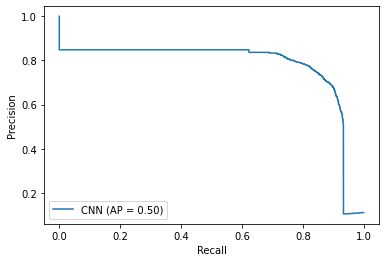

In [ ]:
eval_cnns(model1, val_data)

## Load previous models

In [31]:
model1 = torch.load("archive/3cnn_30eps_94-157.model")

In [ ]:
model2 = torch.load("1lstm-60eps.model")

## Define LSTM

In [23]:
FEATURES_LSTM = 1 
EPOCHS_LSTM = 25

In [24]:
def prepare_input(word_features, preds, times, grad=True):
  utts = word_features.shape[0]
  words = word_features.shape[1]
  feats = word_features.shape[2]
  total_input = torch.zeros(utts, words, 1)

  for idx in range(len(times)):
    timetable = times[idx]
    for jdx in range(len(timetable)):
      span = timetable[jdx]
      if span[1] != 0. and span[0] != span[1]:
        start = int(span[0]) + 1
        end = int(span[1]) + 1
        total_input[idx, jdx, -1] = sum(preds[idx][start:end])

  total_input = total_input.clone().to(device).requires_grad_(grad)
  return total_input

In [50]:
class LSTMClassifier(nn.Module):
    
    def __init__(self):

        super(LSTMClassifier, self).__init__()

        self.lstm_1 = nn.LSTM(input_size=FEATURES_LSTM, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        self.dense_1 = nn.Linear(in_features=256, out_features=1)

        self.dropout_1 = nn.Dropout(0.5)
        self.relu = nn.ReLU()
                
    def forward(self, inputs):
        x, discard = self.lstm_1(inputs)
        x, lengths = pad_packed_sequence(x, batch_first=True, total_length=40)
        x = self.relu(x)
        x = self.dropout_1(x)
        x = self.dense_1(x)

        return x, lengths

In [51]:
model2 = LSTMClassifier().to(device)

In [52]:
loss_func = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

In [53]:
def get_seq_len(arr, idx):
  if isinstance(idx, torch.Tensor):
    seq_lens = torch.tensor([torch.tensor(len(arr[i]), dtype=torch.int64) for i in idx], dtype=torch.int64)
  else:
    seq_lens = torch.tensor([len(arr[idx])], dtype=torch.int64)
  return seq_lens

## Train LSTM

In [54]:
def collect_metrics(m2_preds, batch_lengths, word_labels, indices):
  act_sig = nn.Sigmoid()
  preds = np.concatenate([act_sig(m2_preds[i, :batch_lengths[i], :]).cpu().detach().numpy() for i in range(len(m2_preds))]).flatten()
  preds_bin = np.where(preds > 0.5, 1, 0)
  labels = np.array(np.concatenate(word_labels[indices.cpu()]).flatten(), dtype=int)
  return preds_bin, labels

In [55]:
model_num = 1

In [ ]:
model2.train()
max_e_f1 = 0

for e in range(1, EPOCHS + 1):

  e_loss = e_f1 = 0
  e_labels = e_preds_bin = np.array([])

  for batch in train_loader:
      frame_feature_batch = batch["features"].to(device)
      frame_label_batch = batch["labels"].to(device)
      frame_time_batch = batch["times"].to(device)

      word_feature_batch = batch["words"].to(device)
      word_label_batch = batch["words_labels"].to(device)

      indices = batch["indices"].to(device)

      frame_time_batch = frame_time_batch.clone().detach().requires_grad_(True)

      optimizer.zero_grad()

      m1_preds = model1(frame_feature_batch, frame_time_batch)
      m2_input = prepare_input(word_feature_batch, m1_preds, frame_time_batch)

      
      m2_input_packed = pack_padded_sequence(m2_input, get_seq_len(train_words, indices), batch_first=True, enforce_sorted=False)

      m2_preds, batch_lengths = model2(m2_input_packed)

      loss = loss_func(m2_preds, word_label_batch)

      loss.backward()
      optimizer.step()
      e_loss += loss.item()

      preds_bin, labels = collect_metrics(m2_preds, batch_lengths, train_words_labels, indices)
      e_labels = np.concatenate([e_labels, labels])
      e_preds_bin = np.concatenate([e_preds_bin, preds_bin])

  print(classification_report(e_labels, e_preds_bin, digits=4))
  results = classification_report(e_labels, e_preds_bin, output_dict=True)
    
  e_f1 = results["1.0"]["f1-score"]

  print(f'Epoch {e+0:03}: | Loss: {e_loss/len(train_loader):.5f}')

  if e_f1 > max_e_f1:
    for file in glob(f"model_store/frame_level/model-{model_num}*"):
      os.remove(file)
    
    torch.save(model2, f"model_store/frame_level/model-{model_num}_epoch-{e}_f1-{e_f1:.3f}.pt")
    max_e_f1 = e_f1
  else:
    pass


## Evaluate LSTM

In [33]:
val_data = DatasetWithTimings(val_features, val_labels, val_times, val_words, val_words_labels, 3)

Labels input shape: torch.Size([873, 173, 1])
Features input shape: torch.Size([873, 7, 1378])
Timestamps input shape: torch.Size([873, 38, 2])
Word features input shape: torch.Size([873, 38, 23])
Word labels input shape: torch.Size([873, 38, 1])


In [58]:
model_file = "model-1_epoch-29_f1-0.807.pt"
eval_model = torch.load(f"model_store/frame_level/{model_file}")
eval_model.eval()

val_features = val_data.features_input.to(device)
val_times = val_data.times_input.to(device)
val_labels = val_data.labels_input.to(device)
val_word_features = val_data.words_input.to(device)
val_word_labels = val_data.words_labels_input.to(device)
val_indices = torch.tensor([x for x in range(len(val_data.words))])

val_m1_preds = model1(val_features, val_times)
val_m2_input = prepare_input(val_word_features, val_m1_preds, val_times)
val_m2_input_packed = pack_padded_sequence(val_m2_input, get_seq_len(val_data.words, val_indices), batch_first=True, enforce_sorted=False)
val_m2_preds, val_batch_lengths = eval_model(val_m2_input_packed)

val_preds_bin, val_labels = collect_metrics(val_m2_preds, val_batch_lengths, val_data.words_labels, val_indices)
with open(f"eval/frame_level/{model_file}.txt", "w") as reportfile:
  reportfile.write(classification_report(val_labels, val_preds_bin, digits=4))

In [ ]:
torch.save(model2, "1lstm-30eps.model")